# MITGCM Regional Time Scale Analysis 

**Purpose**: Code for preforming the regional time scale analysis. I will compute the decorrelation time scale for a subset of the model domain at each grid point. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr_optimize, compute_decor_scale_optimize
from spectra import spectrum1D_frequency, spectral_slope
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp'  # Specifies which variable will analyzed. Options include: temp, sal, density
option_depth         = 0.5    # Specifies the depth level in meter at which the decorrelation data is computed

# Set time and space parameters
T            = 1*(60)*(60)                   # Spcifies the time interval for model run. Units: seconds
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function    
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/'
PATH_figs =  ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 16

Load mitgcm data netcdf files 

In [4]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename = PATH + "THETA_CCS4_hrly_ts_ext_depth_" + str(option_depth) + "m.nc"
elif option_var == 'sal':
    filename = PATH + "SALT_CCS4_hrly_ts_ext_depth_" + str(option_depth) + "m.nc"
elif option_var == 'density':
    filename = PATH + "RHO_CCS4_hrly_ts_ext_depth_" + str(option_depth) + "m.nc"
nc = Dataset(filename, 'r')

# Extract data variables
water_depth   = nc.variables['Depth'][:]

lon = nc.variables['XC'][:]
lat = nc.variables['YC'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

if option_var == 'temp':
    data = nc.variables['THETA'][:]
elif option_var == 'sal':
    data = nc.variables['SALT'][:]
elif option_var == 'density':
    data = nc.variables['RHO'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Read in bathymetry data

In [5]:
# Load bathymetry data 
filename = PATH_bathy + "topo_25.1.nc"
ds_bathy = xr.open_dataset(filename, engine="netcdf4")

# Extract data variables
lon_b = ds_bathy["lon"]  # Longitude
lat_b = ds_bathy["lat"]  # Latitude
bathy = ds_bathy["z"]    # Elevation/Bathymetry

# Convert convesion of longitude (neg from the prime meridian to positive definite wrapping around the earth)
lon_n = lon_b % 360

# Set max and min values 
lon_min = lon_bnds[0]
lon_max = lon_bnds[1]
lat_min = lat_bnds[0]
lat_max = lat_bnds[1]

# Extract data from bathymetry 
lon_grid = lon_n[(lon_n >= lon_min) & (lon_n <= lon_max)]
lat_grid = lat_b[(lat_b >= lat_min) & (lat_b <= lat_max)]
bathy_grid   = bathy[(lat_b >= lat_min) & (lat_b <= lat_max),(lon_n >= lon_min) & (lon_n <= lon_max)]

Plot the spatial domain

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


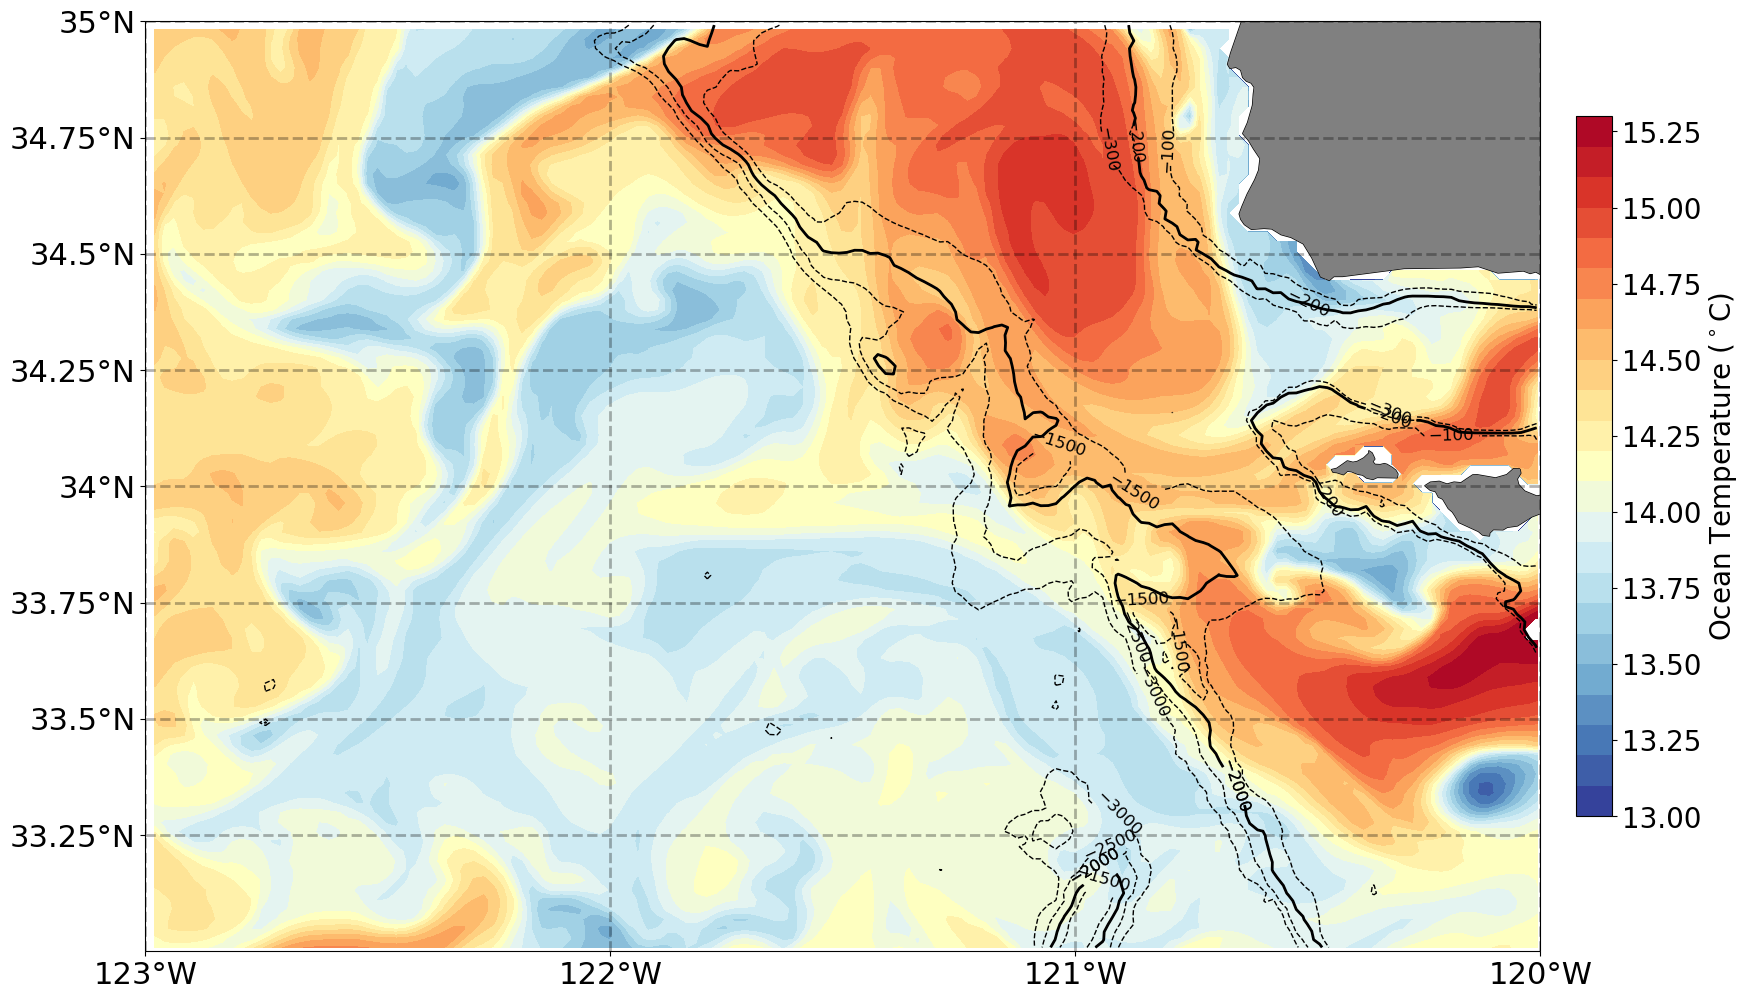

In [36]:
# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-123, -122, -121, -120]
yticks = [33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75, 35.00]
resolution = "10m"
bounds = np.arange(0,360+40,40)
lon_min = -123
lon_max = -120
lat_min = 33
lat_max = 35

# Specify data specific attributes 
if option_var == 'temp':
    cmap = 'RdYlBu_r'
    label = r'Ocean Temperature ($^\circ$C)'
    levels = np.arange(13,15.25+0.1,0.1) #np.arange(13,14.8+0.05,0.05) # np.arange(13,15.25+0.1,0.1) #np.arange(13.2,14.7+0.1,0.05) #np.arange(13.2,16+0.1,0.1)
elif option_var == 'sal':
    cmap = 'BrBG_r'
    label = r'Salinity (psu)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    cmap = 'Spectral_r'
    label = r'$\sigma_0$ (kg m$^{-3}$)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, data[100,:,:], levels=levels, # 100, 400
    transform=ccrs.PlateCarree(),
    cmap=cmap,  
    shading="auto"
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=label,
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure
fig.savefig(fname = PATH_figs + option_var + '_spatial_map_ts', bbox_inches = 'tight', dpi=300)

Preform scale analysis

In [9]:
# Set parameters
ntime,nlat,nlon = np.shape(data)
lag = ntime
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/sec
M = 20                                                       # Specifies number of windows to divide the data into for the Welch method
p = ntime // M                                               # Specifies window length, i.e., number of data points in each segment
nfft = (p // 2 + 1) if (p % 2 == 0) else ((p - 1) // 2)      # Specifies number of positive frequency bins in the resulting power spectrum
df = 1 / (p * T)                                             # Specifies the frequency resolution of the power spectrum
units = 'Hz'

# Convert to seconds since start time
t0 = time_dt[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time_dt])

# Define frequency range for slope fitting (sub-interial and super-inertial)
fmin_sub = 6*10**(-2) 
fmax_sub = 6*10**(-1) 
fmin_sup = 2*10**(0)
fmax_sup = 1.25*10**(1)

# Initialize arrays 
autocorr       = np.zeros((ntime,nlat,nlon))
time_scale     = np.zeros((ntime,nlat,nlon))
L_t            = np.zeros((nlat,nlon))
rms            = np.zeros((nlat,nlon))
fve            = np.zeros((nlat,nlon))
phase_a        = np.zeros((nlat,nlon))
phase_sa       = np.zeros((nlat,nlon))
amp_a          = np.zeros((nlat,nlon))
amp_sa         =  np.zeros((nlat,nlon))
sigma_phase_a  = np.zeros((nlat,nlon))
sigma_phase_sa = np.zeros((nlat,nlon))
sigma_amp_a    = np.zeros((nlat,nlon))
sigma_amp_sa   = np.zeros((nlat,nlon))
S              = np.zeros((nfft,nlat,nlon))
CI             = np.zeros((nfft,2,nlat,nlon))
slope_sub      = np.zeros((nlat,nlon))
slope_unc_sub  = np.zeros((nlat,nlon))
slope_sup      = np.zeros((nlat,nlon))
slope_unc_sup  = np.zeros((nlat,nlon))
mean_period    = np.zeros((nlat,nlon))
cn_lon = 0 

# Loop through longitude 
for ilon in range(0,nlon):
    
    # Set progress bar
    progress = (ilon + 1) / (len(lon)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Set latitude counter 
    cn_lat = 0

    # Loop through latitude
    for ilat in range(0,nlat):
        
        # Initialize the ith time series 
        data_ts = data[:,ilat,ilon]

        # Remove annual and semi-annual cycle 
        hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
        data_ts_rm = data_ts - hfit

        # Compute the rmse, phase and amplitude of the annual and semi-annual cycles and their uncertainities
        # _, rms[cn_lat,cn_lon], fve[cn_lat,cn_lon], iamp, iphase = compute_amp_phase(data_ts, hfit, x_data, parameters = 2)
        # isigma_amp, isigma_phase = compute_amp_phase_unc(x_data, x_data_sigma, parameters = 2)

        # # Save the phase and amplitude plus their uncertainties to the arrays
        # phase_a[cn_lat,cn_lon], phase_sa[cn_lat,cn_lon] = iphase[0], iphase[1]
        # amp_a[cn_lat,cn_lon], amp_sa[cn_lat,cn_lon] = iamp[0], iamp[1]
        # sigma_phase_a[cn_lat,cn_lon], sigma_phase_sa[cn_lat,cn_lon] = isigma_phase[0], isigma_phase[1]
        # sigma_amp_a[cn_lat,cn_lon], sigma_amp_sa[cn_lat,cn_lon] = isigma_amp[0], isigma_amp[1]

        # Detrend data record 
        data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

        # Compute autocorrelation function
        # autocorr[:,cn_lat,cn_lon], _, _, _, time_scale[:,cn_lat,cn_lon], _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

        # # Compute the decorrelation scale
        # L_t[cn_lat,cn_lon] = compute_decor_scale_optimize(autocorr[:,cn_lat,cn_lon],time_scale[:,cn_lat,cn_lon],T,'unbiased',0)

        # Compute frequency power spectrum 
        S[:,cn_lat,cn_lon], f, CI[:,:,cn_lat,cn_lon], _ = spectrum1D_frequency(data_ts, T, M, units)

        # Compute the energy-containing scales
        f_zero = f[f > 0]
        S_zero = S[f > 0,cn_lat,cn_lon]
        spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
        mean_period[cn_lat,cn_lon] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

        # Compute the sub-inertial and super inertial spectral slope
        f_cpd = f*(60)*(60)*(24)
        slope_sub[cn_lat,cn_lon], slope_unc_sub[cn_lat,cn_lon], _, _ = spectral_slope(f_cpd, S[:,cn_lat,cn_lon], fmin_sub, fmax_sub)
        slope_sup[cn_lat,cn_lon], slope_unc_sup[cn_lat,cn_lon], _, _ = spectral_slope(f_cpd, S[:,cn_lat,cn_lon], fmin_sup, fmax_sup)

        # Compute structure function
        #S_i, lag_i = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

        # Set latitude counter
        cn_lat = cn_lat + 1

    # Set longitude counter
    cn_lon = cn_lon + 1

# Convert time scale to units of months
#L_tm = L_t*(1/60)*(1/60)*(1/24)*(1/30)


Progress: 79.0%

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_38564/1493408176.py:90: RuntimeWarning: invalid value encountered in scalar divide
  spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/spectra.py:99: RuntimeWarning: divide by zero encountered in log10
  Ei = np.log10(E[idx])


Progress: 100.7%

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


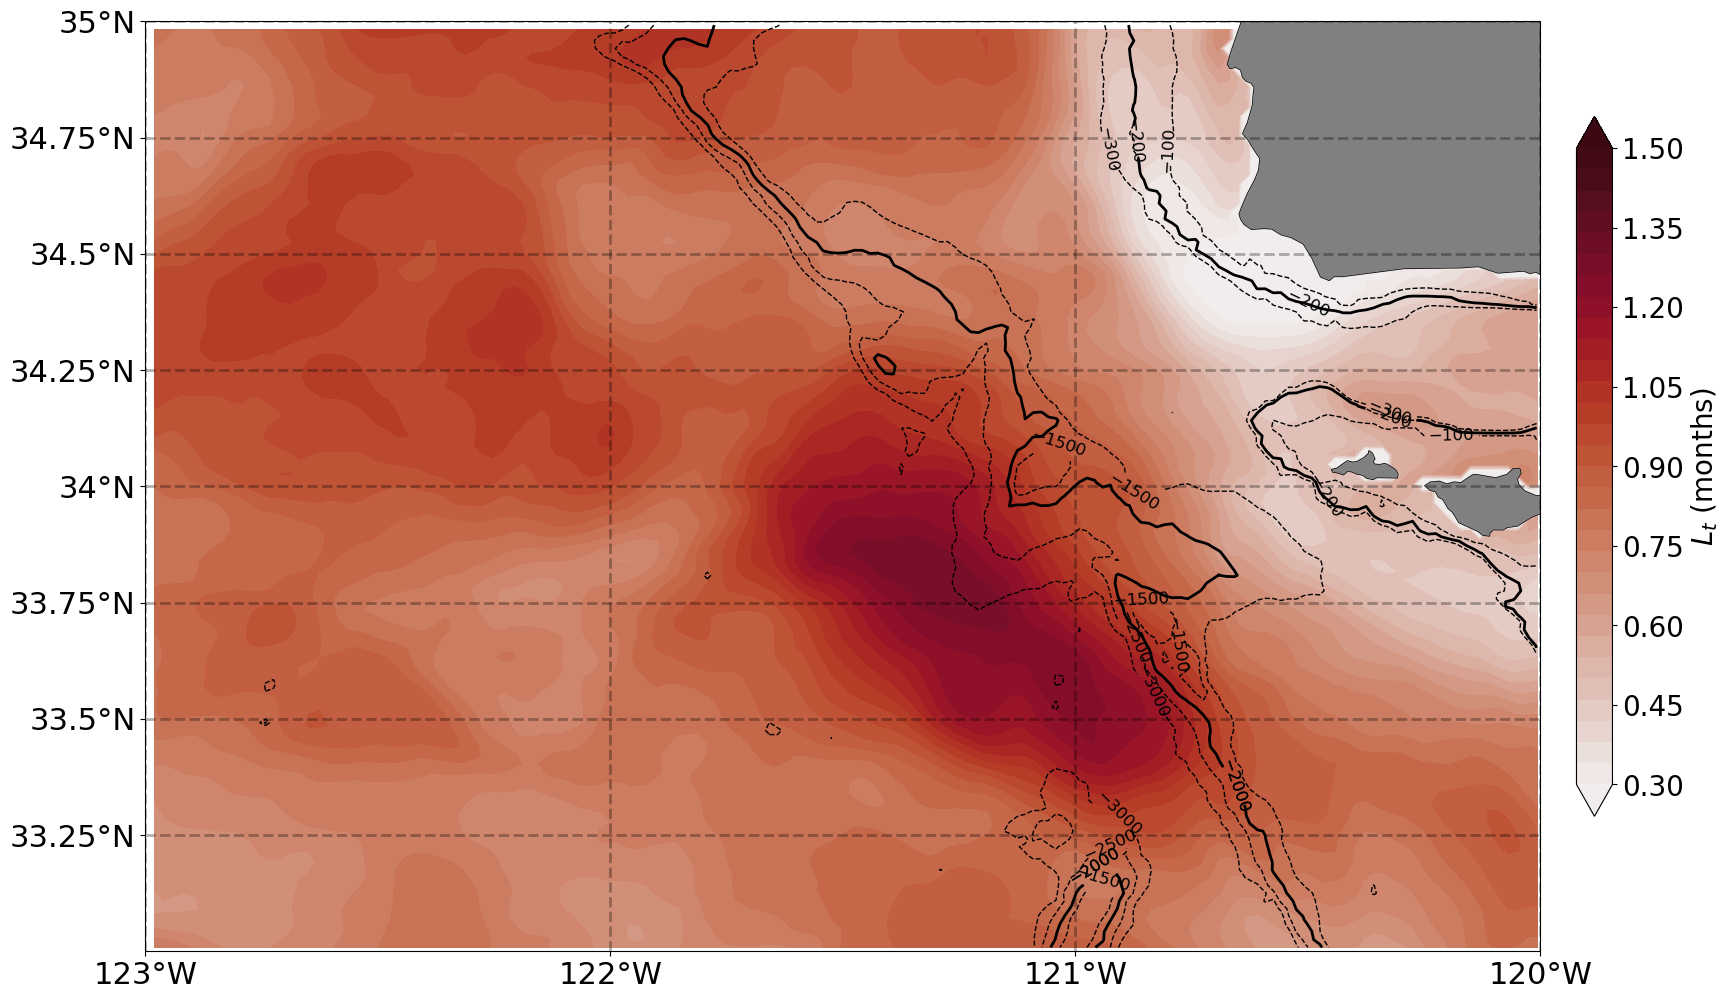

In [ ]:
# Set plotting parameters 
levels = np.arange(0.30,1.5 + 0.04,0.04) 

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot temporal decorrelation scale
mesh = axes.contourf(
    lon, lat, L_tm, levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'$L_t$ (months)',
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH_figs + 'time_decorr_scale_' + option_var + '_spatial_map_depth_' + str(option_depth) + 'm.png' , bbox_inches = 'tight', dpi=300)

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


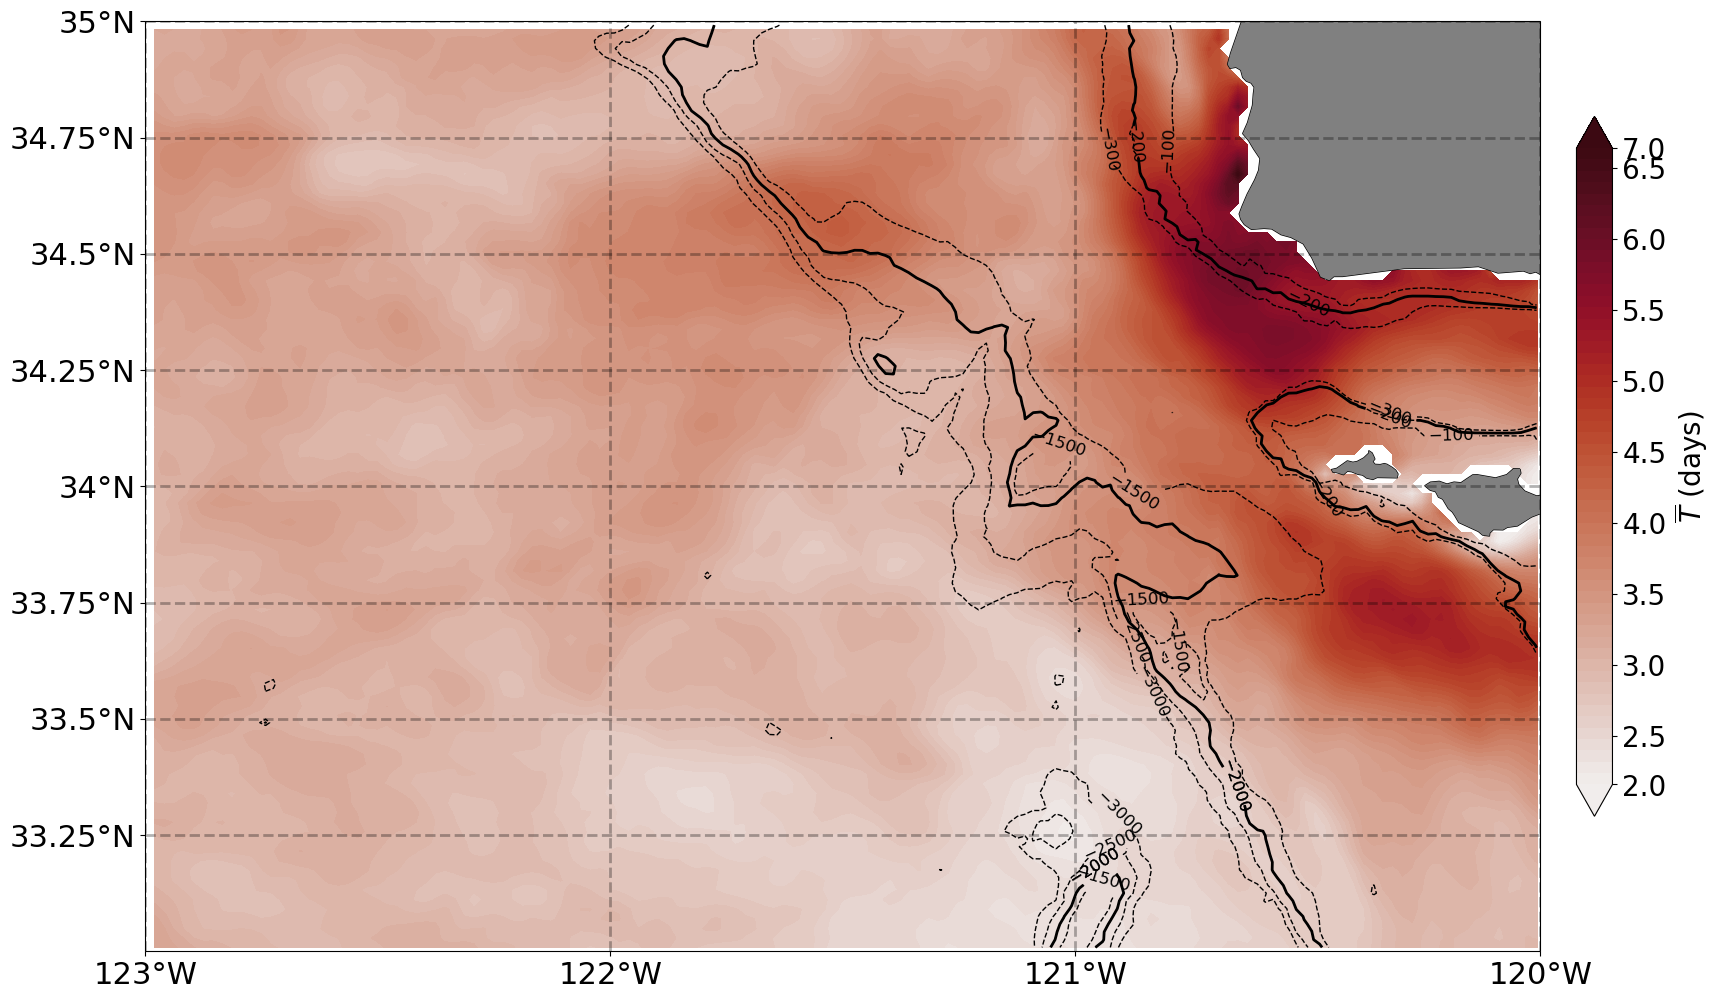

In [13]:
# Set plotting parameters 
levels = np.arange(0.30,1.5 + 0.04,0.04) 

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot temporal decorrelation scale
mesh = axes.contourf(
    lon, lat, mean_period, levels=60,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'$\overline{T}$ (days)',
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH_figs + 'time_decorr_scale_' + option_var + '_spatial_map_depth_' + str(option_depth) + 'm.png' , bbox_inches = 'tight', dpi=300)


/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


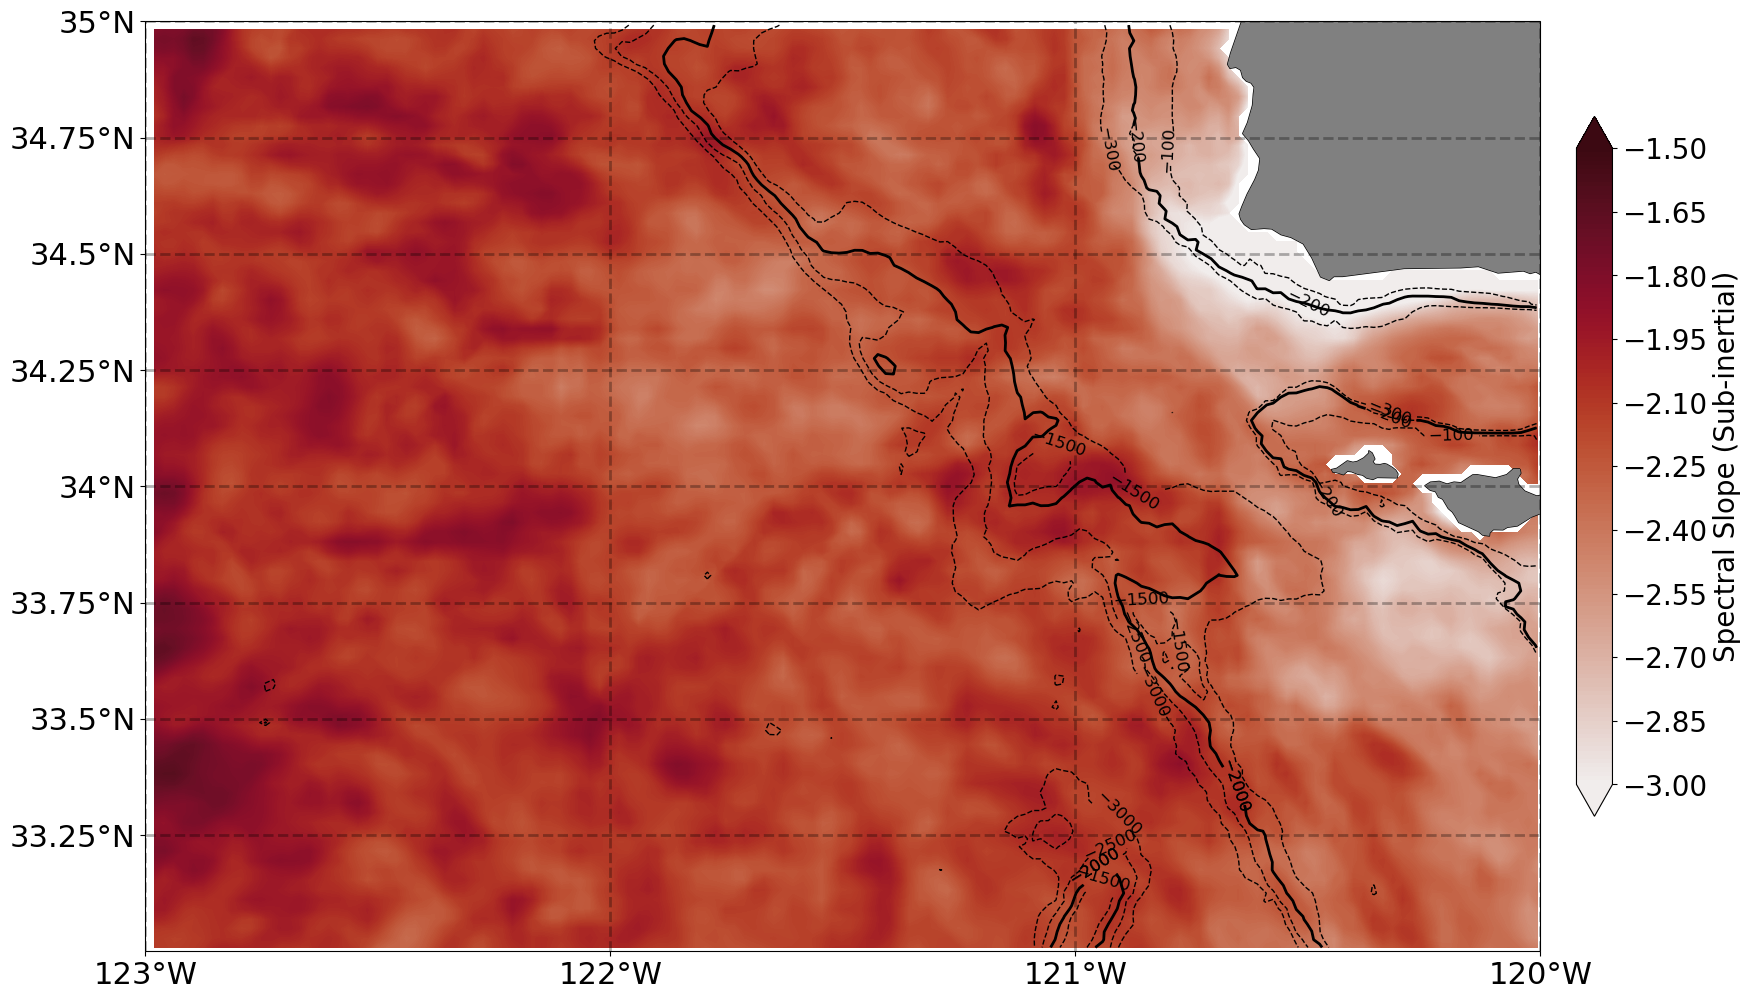

In [ ]:
# Set plotting parameters 
levels = np.arange(-3,-1.5 + 0.01,0.01) 

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot temporal decorrelation scale
mesh = axes.contourf(
    lon, lat, slope_sub, levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'Spectral Slope (Sub-inertial)',
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure 
#fig.savefig(fname = PATH_figs + 'time_decorr_scale_' + option_var + '_spatial_map_depth_' + str(option_depth) + 'm.png' , bbox_inches = 'tight', dpi=300)


/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


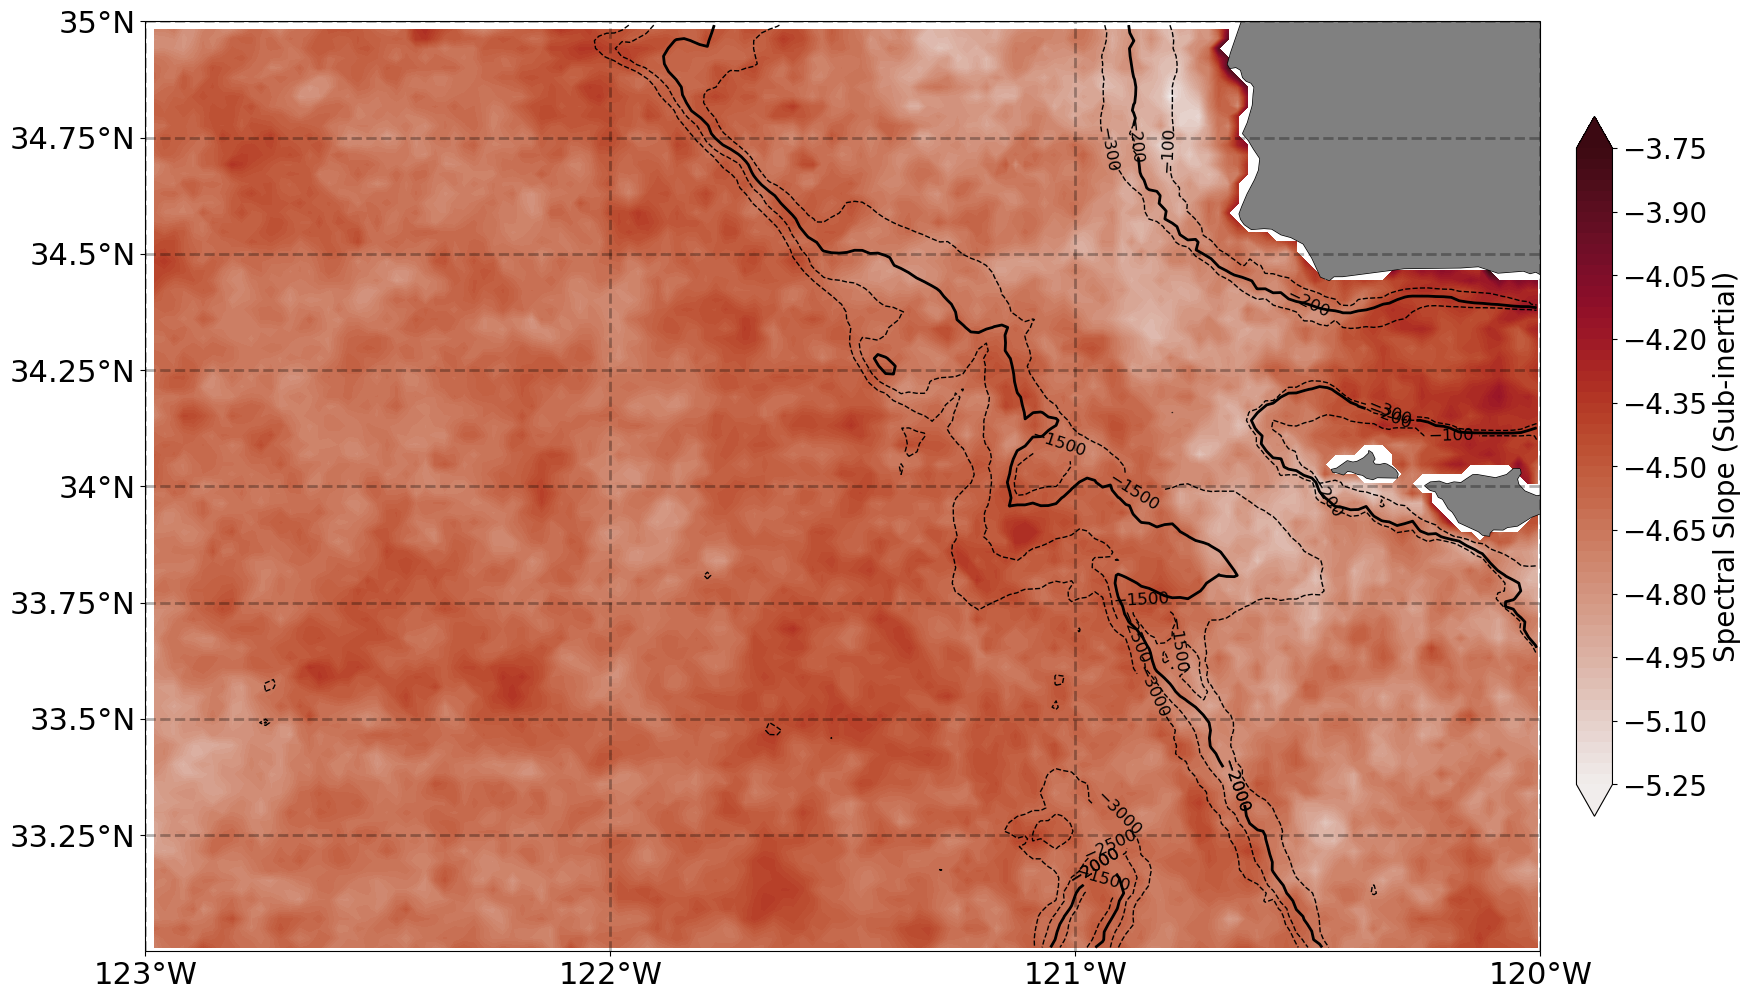

In [20]:
# Set plotting parameters 
levels = np.arange(-3,-1.5 + 0.01,0.01) 

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot temporal decorrelation scale
mesh = axes.contourf(
    lon, lat, slope_sup, levels=60,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'Spectral Slope (Sub-inertial)',
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure 
#fig.savefig(fname = PATH_figs + 'time_decorr_scale_' + option_var + '_spatial_map_depth_' + str(option_depth) + 'm.png' , bbox_inches = 'tight', dpi=300)


/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


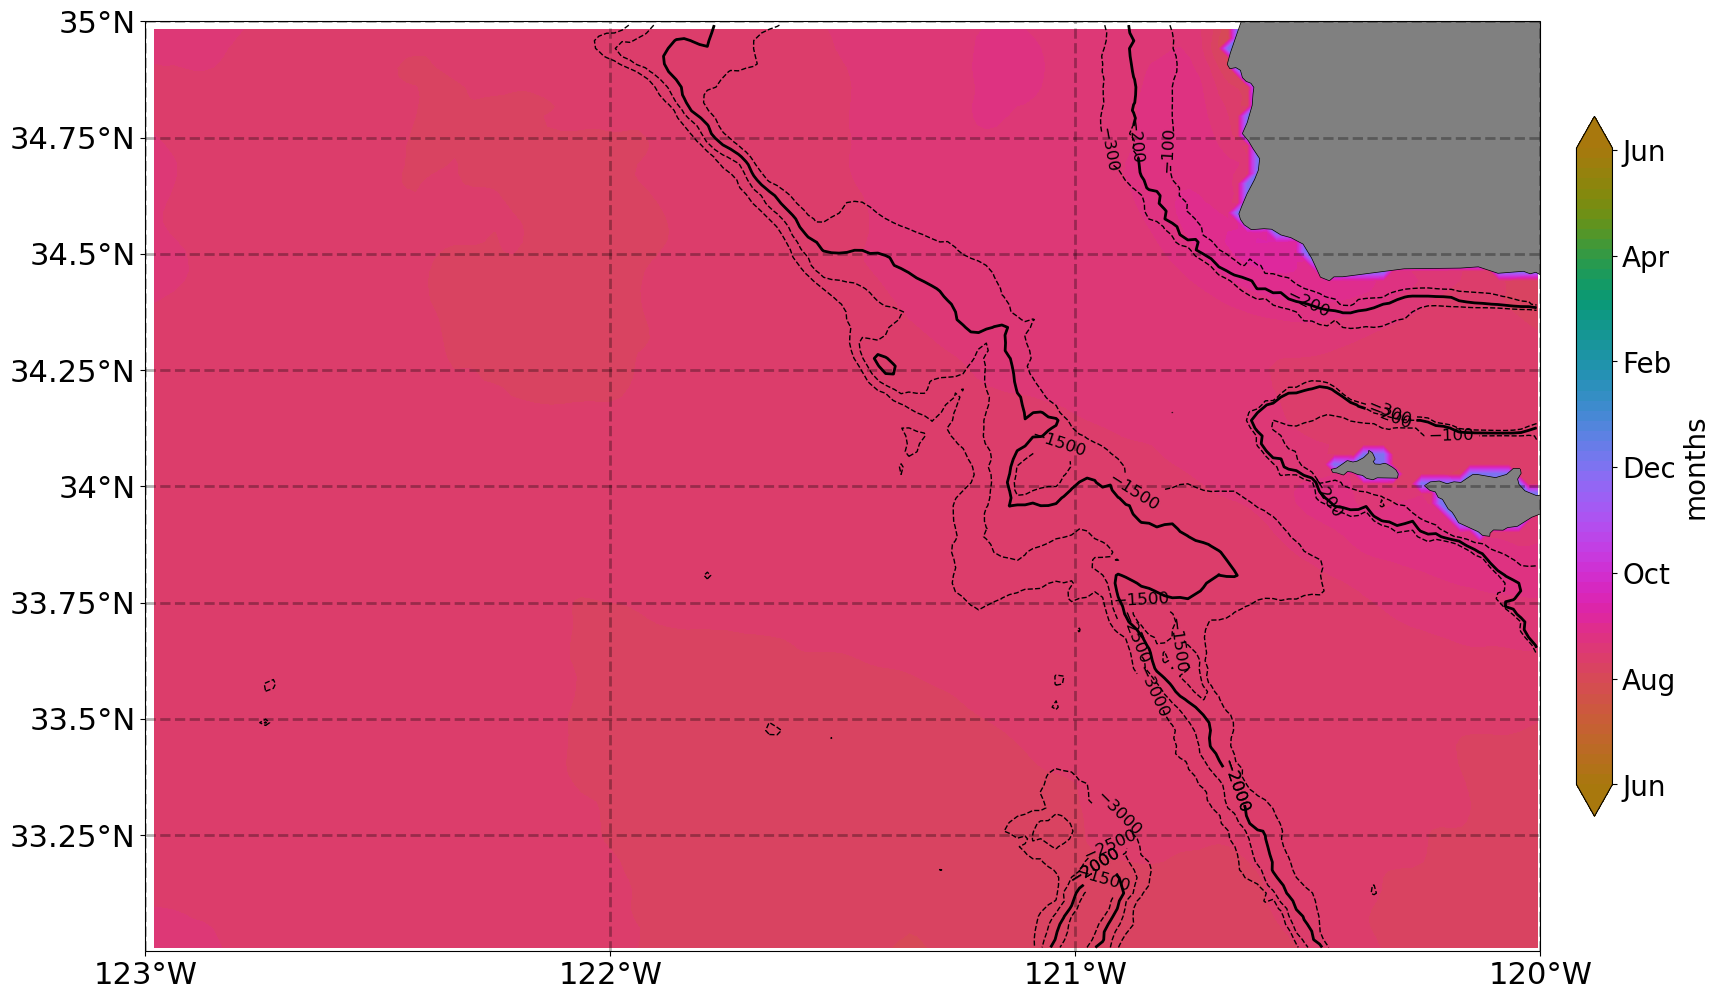

In [10]:
# Set plotting parameters 
levels = np.arange(-np.pi,np.pi + 0.1,0.1)
parameter = 'phase_annual'

# Set noise to signal ratio criteria
ns = 5 / 10

#--- Mask not statistical significance ---#

# Compute the relative uncertainty
a_ratio = sigma_amp_a / amp_a
s_ratio = sigma_amp_sa / amp_sa

# Mask not statistically significant grid points
a_mask = np.ma.getmask(np.ma.masked_greater_equal(a_ratio, (ns)))
s_mask = np.ma.getmask(np.ma.masked_greater_equal(s_ratio, (ns)))

# Apply statistical significance masks
phase_a_m = np.ma.masked_where(a_mask, phase_a)
amp_a_m = np.ma.masked_where(a_mask, amp_a)
phase_sa_m = np.ma.masked_where(s_mask, phase_sa)
amp_sa_m = np.ma.masked_where(s_mask, amp_sa)

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot annual cycle phase 
mesh = axes.contourf(
    lon, lat, phase_a_m, levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.phase,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'months',
    nbins=7,
    fontsize=20,
    cbar_ticks=[
        np.arange(-np.pi, np.pi + 0.5, (np.pi + np.pi) / 6).tolist(),
        ["Jun", "Aug", "Oct", "Dec", "Feb", "Apr", "Jun"],
    ],
    task="custom ticks",
)

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH_figs + 'time_' + parameter + '_' + option_var + '_spatial_map_depth_' + str(option_depth) + 'm.png', bbox_inches = 'tight', dpi=300)


/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


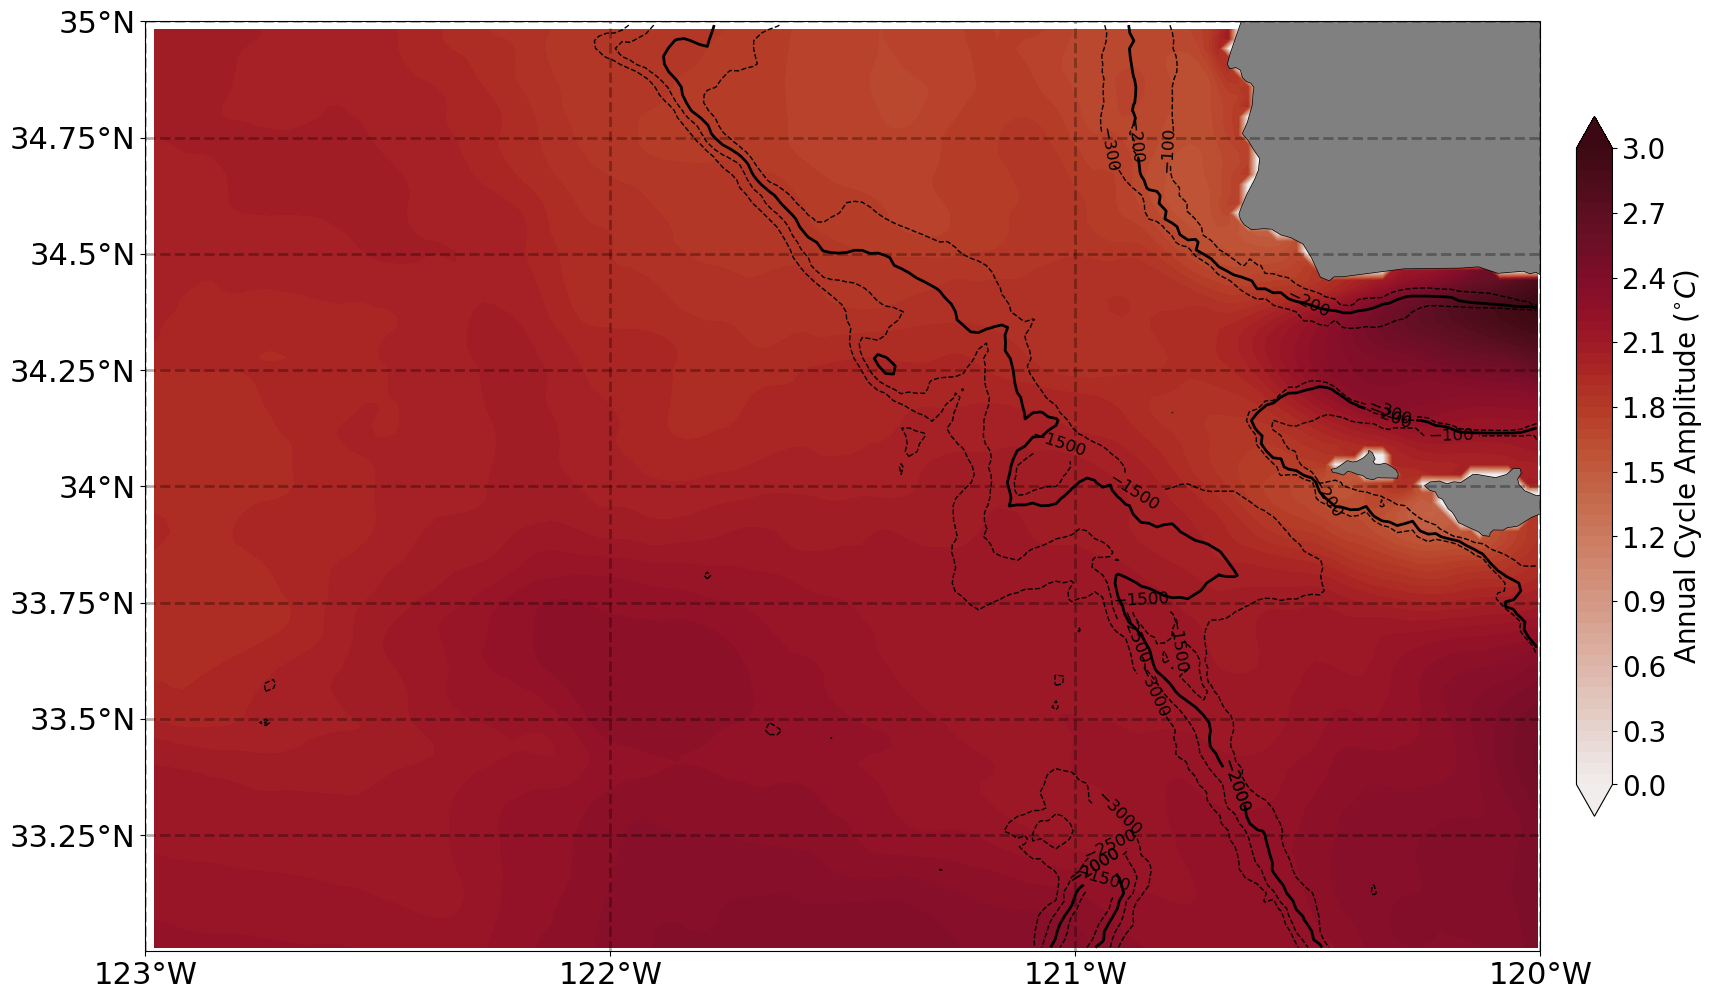

In [11]:
# Set plotting parameters 
levels = np.arange(1,3,0.05) #np.arange(0,1,0.025) 
parameter = 'amp_a'

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, amp_a, levels=60,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'Annual Cycle Amplitude ($^{\circ}C)$',
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH_figs + 'time_' + parameter + '_' + option_var + '_spatial_map_depth_' + str(option_depth) + 'm.png', bbox_inches = 'tight', dpi=300)


/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


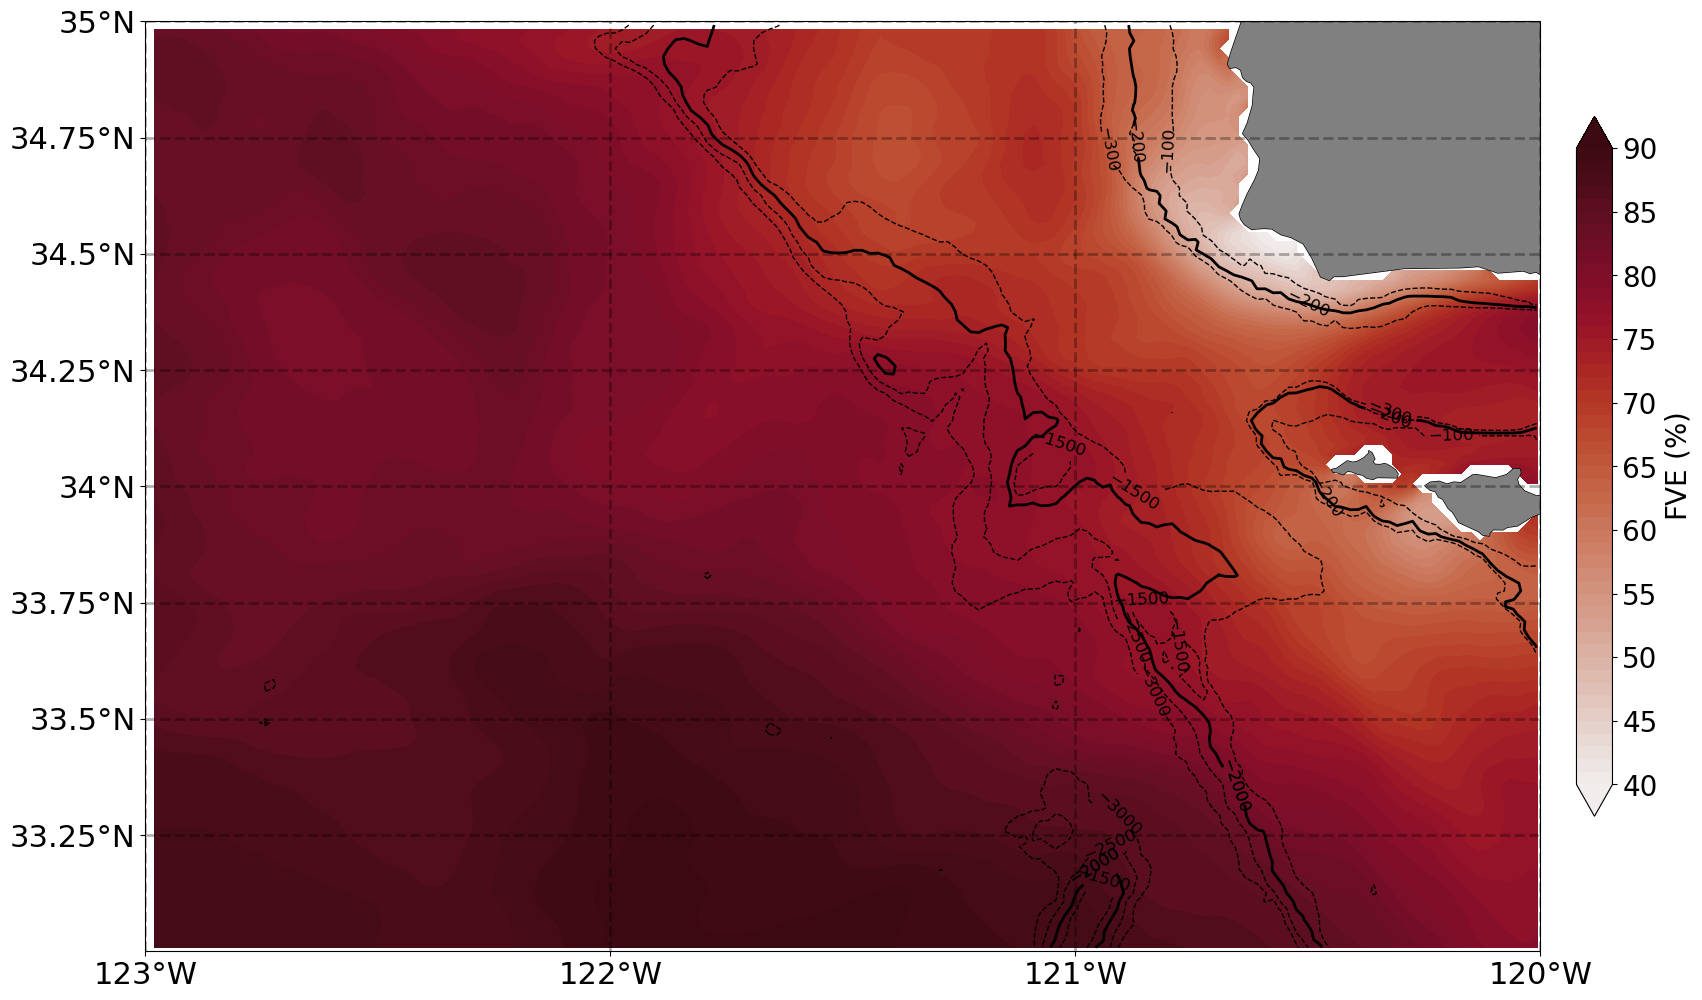

In [12]:
# Set plotting parameters 
levels = np.arange(40,100+2,2)
parameter = 'fve'

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, fve*100, levels=60,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'FVE ($\%)$',
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH_figs + 'time_' + parameter + '_' + option_var + '_spatial_map_depth_' + str(option_depth) + 'm.png', bbox_inches = 'tight', dpi=300)


/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


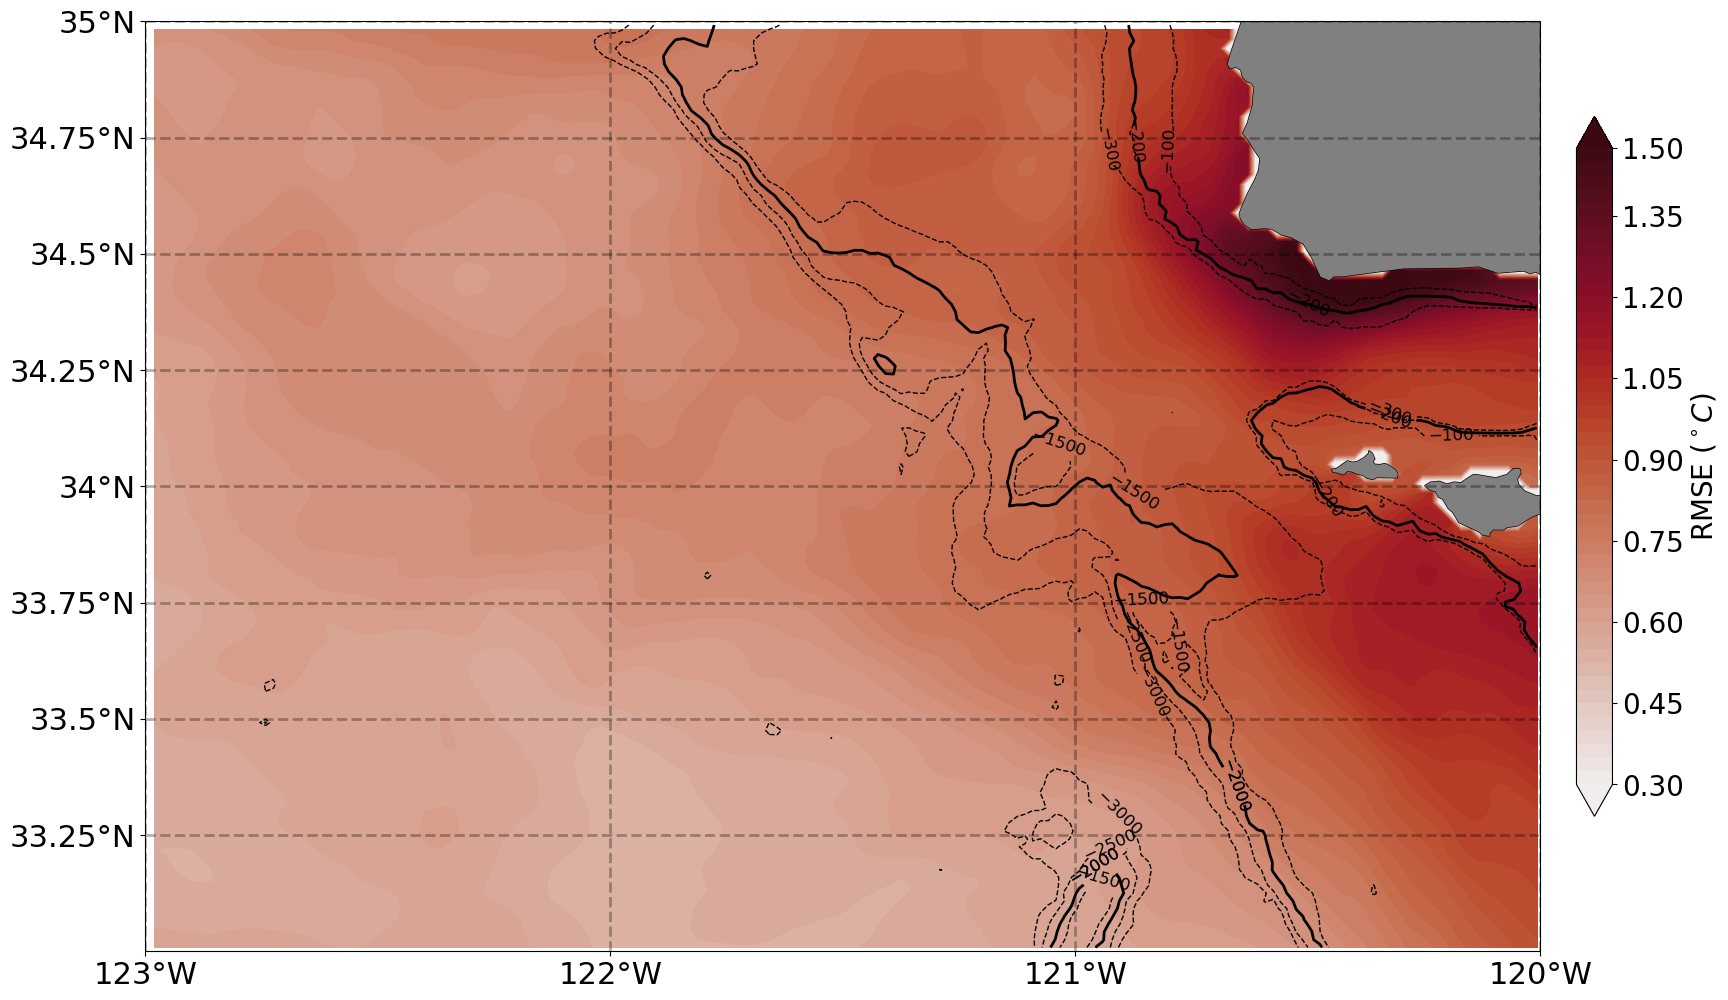

In [13]:
# Set plotting parameters 
levels = np.arange(0.3,1.5,0.025)
parameter = 'rms'

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, rms, levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'RMSE ($^\circ C)$',
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure 
fig.savefig(fname = PATH_figs + 'time_' + parameter + '_' + option_var + '_spatial_map_depth_' + str(option_depth) + 'm.png', bbox_inches = 'tight', dpi=300)


Save intermediate data 

In [ ]:
#--- Autocorrelation and decorrelation scales ---# 

# Check if file exists, then delete it
file_path = PATH + "/mitgcm_temporal_decorr_scale_" + option_var  + "_depth_" + str(option_depth) + "m.npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'Temporal decorrelation length scale from the MIT gcm model out of ' + option_var + ' at depth ' + str(option_depth) + 'm. Here, the annual and semi-annual cycles are removed before computing the decorrelation scale.',
    'source': 'MITgcm model data from SWOT_MARA_RUN4_LY',
    'coordinates units': 'km'
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        autocorr        = autocorr,
        L_tm            = L_tm,          # Units: months
        time_scale      = time_scale,    # Units: seconds
        lon             = lon,
        lat             = lat,
        metadata        = metadata
        )

#--- Annual and Semi-Annual Cycle Model Parameters ---# 

# Check if file exists, then delete it
file_path = PATH + "/mitgcm_temporal_lsf_model_parameters_" + option_var  + "_depth_" + str(option_depth) + "m.npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'Temporal unweighted least squares fit model parameters from the MIT gcm model out of ' + option_var + ' at depth ' + str(option_depth) + 'm. Here, the annual and semi-annual cycles are fitted and the rms error, fraction of variance explained, phase and amplitude along with their uncertainties are computed.',
    'source': 'MITgcm model data from SWOT_MARA_RUN4_LY',
    'coordinates units': 'km'
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        rms             = rms,
        fve             = fve,
        phase_a         = phase_a,
        phase_sa        = phase_sa, 
        amp_a           = amp_a, 
        amp_sa          = amp_sa, 
        sigma_phase_a   = sigma_phase_a, 
        sigma_phase_sa  = sigma_phase_sa, 
        sigma_amp_a     = sigma_amp_a, 
        sigma_amp_sa    = sigma_amp_sa, 
        lon             = lon,
        lat             = lat,
        metadata        = metadata
        )

#--- Power Spectral Density Function ---# 

# Check if file exists, then delete it
file_path = PATH + "/mitgcm_temporal_psd_" + option_var  + "_depth_" + str(option_depth) + "m_numWindows_" + str(M) + ".npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'Temporal power spectral density function from the MIT gcm model out of ' + option_var + ' at depth ' + str(option_depth) + 'm. Spectral Parameters: Number of windows: ' + str(M) + ', df: ' + str(np.round(df,9)) + '.',
    'source': 'MITgcm model data from SWOT_MARA_RUN4_LY',
    'coordinates units': 'km'
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        S               = S,            # Units: ( )^2/Hz
        CI              = CI,
        f               = f,            # Units: Hz
        lon             = lon,
        lat             = lat,
        metadata        = metadata
        )